In [61]:
%%bash

# 增加更新
git add .

git remote -v

git commit -m '更新 ch8 #4 change Jul 30, 2021'

git push origin master

Process is interrupted.
time: 25.9 s (started: 2021-07-30 12:20:04 +08:00)


In [1]:
# 自动计算cell的计算时间
%load_ext autotime

#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

time: 8.78 s (started: 2021-07-30 08:58:13 +08:00)


In [2]:
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 21 ms (started: 2021-07-30 08:58:29 +08:00)


# 计算机视觉深度学习简介

**本章包含**
* 理解卷积神经网络 (convnets)
* 使用数据增强来减轻过拟合
* 使用预训练的 convnet 进行特征提取
* 微调预训练的卷积网络

计算机视觉是深度学习最早也是最大的成功案例。 每天，您都在与深度视觉模型进行交互——通过 Google 照片、Google 图像搜索、YouTube、相机应用程序中的视频过滤器、OCR 软件等等。 这些模型也是自动驾驶、机器人、人工智能辅助医疗诊断、自动零售结账系统，甚至自动农业领域前沿研究的核心。

计算机视觉是导致 2011 年至 2015 年深度学习最初兴起的问题领域。 一种称为卷积神经网络的深度学习在那个时候开始在图像分类比赛中取得非常好的成绩，首先是 Dan Ciresan 赢得了两场小众比赛 （ICDAR 2011 汉字识别比赛和 IJCNN 2011 德国交通标志识别比赛），然后更引人注目的是在 2012 年秋季，Hinton 的团队赢得了备受瞩目的 ImageNet 大规模视觉识别挑战。 许多更有希望的结果很快开始出现在其他计算机视觉任务中。

有趣的是，这些早期的成功在当时还不足以使深度学习成为主流——这花了几年时间。 计算机视觉研究社区已经花了很多年时间投资于神经网络以外的方法，但还没有准备好仅仅因为有一个新孩子就放弃这些方法。 2013 年和 2014 年，深度学习仍然面临着许多资深计算机视觉研究人员的强烈怀疑。 直到 2016 年，它才终于占据主导地位。 我记得 2014 年 2 月曾劝告我的一位前教授转向深度学习。 “这是下一件大事！”，我会说。 “嗯，也许这只是一种时尚。”，他回答道。 到 2016 年，他的整个实验室都在做深度学习。 时机已到的想法是无法阻止的。

本章介绍了卷积神经网络，也称为 卷积神经网络，这是一种现在几乎普遍用于计算机视觉应用的卷积神经网络深度学习模型。 您将学习将 convnet 应用于图像分类问题——尤其是那些涉及小型训练数据集的问题，如果您不是一家大型科技公司，这是最常见的用例。

## 卷积网络简介

我们将深入研究什么是 convnets 以及为什么它们在计算机视觉任务中如此成功的理论。 但首先，让我们实际看看一个简单的 convnet 示例。 它使用 convnet 对 MNIST 数字进行分类，这是我们在第 2 章中使用密集连接网络执行的任务（当时我们的测试准确率为 97.8%）。 尽管 convnet 是基本的，但它的准确性将远远超过第 2 章中的密集连接模型。

以下代码行向您展示了基本的 convnet 是什么样的。 它是一堆 Conv2D MaxPooling2D 层。 一分钟后你就会看到他们到底做了什么。 我们将使用我们在前一章中介绍的 Functional API 来构建模型。

> 清单 8.1 实例化一个小卷积网络

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

time: 2.63 s (started: 2021-07-30 09:00:23 +08:00)


重要的是，convnet 将形状（image_height、image_width、image_channels）（不包括批量维度）的张量作为输入。 在这种情况下，我们将配置 convnet 来处理大小为 (28, 28, 1) 的输入，这是 MNIST 图像的格式。

让我们展示一下我们的 convnet 的架构：

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0     

In [5]:
from tensorflow.keras.utils import plot_model

time: 569 µs (started: 2021-07-28 22:32:43 +08:00)


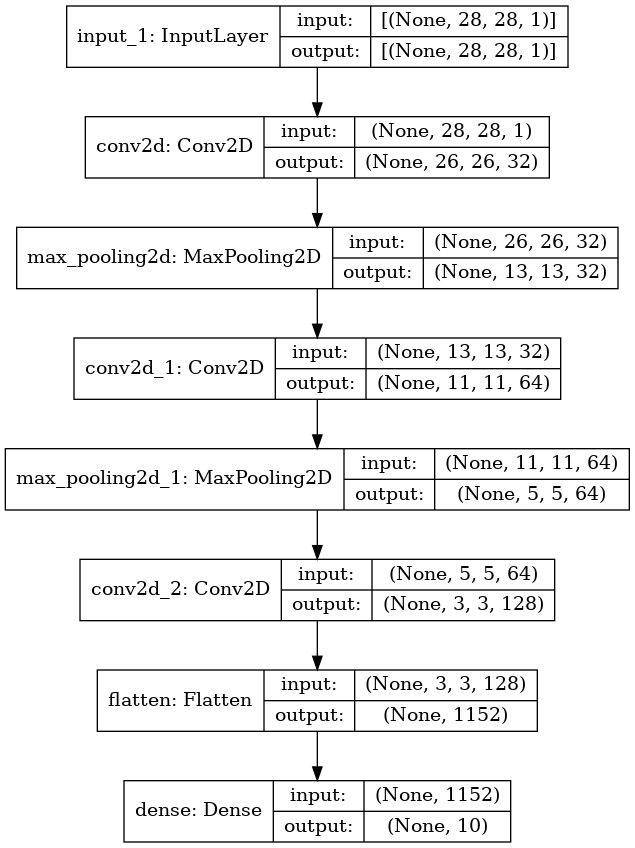

time: 952 ms (started: 2021-07-28 22:32:44 +08:00)


In [ ]:
plot_model(model, show_shapes=True)

可以看到每个和 Conv2D MaxPooling2D 层的输出是一个形状（高度、宽度、通道）的 3D 张量。 随着您深入模型，宽度和高度尺寸往往会缩小。 通道数由传递给 Conv2D 层（32、64 或 128）的第一个参数控制。

在最后一层之后，我们最终得到了形状为 Conv2D (3, 3, 128) 的输出——128 个通道的 3x3 特征图。 下一步是将此输出输入到一个密集连接的分类器中，就像您已经熟悉的分类器：一堆Dense层。 这些分类器处理向量，密集是 1D，而当前输出是 3D 张量。 为了弥补差距，我们在添加`Dense`图层之前使用`Flatten`图层将 3D 输出展平为 1D。

最后，我们将进行 10 路分类，因此我们的最后一层有 10 个输出和一个 softmax 激活。现在，让我们在 MNIST 数字上训练 convnet。 我们将重用第 2 章 MNIST 示例中的大量代码。因为我们使用 softmax 输出进行 10 向分类，所以我们将使用分类交叉熵损失，并且因为我们的标签是整数，我们将 使用稀疏版本 sparse_categorical_crossentropy。

In [7]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 34s 16ms/step - loss: 0.1557 - accuracy: 0.9516
Epoch 2/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0450 - accuracy: 0.9866
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0317 - accuracy: 0.9899
Epoch 4/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0233 - accuracy: 0.9928
Epoch 5/5
938/938 [==============================] - 10s 11ms/step - loss: 0.0182 - accuracy: 0.9943


time: 1min 20s (started: 2021-07-28 22:35:14 +08:00)


让我们在测试数据上评估模型：

In [8]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 5s 12ms/step - loss: 0.0268 - accuracy: 0.9905
time: 4.79 s (started: 2021-07-28 22:36:59 +08:00)


In [9]:
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.990
time: 643 µs (started: 2021-07-28 22:37:13 +08:00)


第 2 章中的密集连接模型的测试准确率为 97.8%，而基本卷积网络的测试准确率为 99.1%：我们将错误率降低了约 60%（相对）。 不错！

但是，与密集连接的模型相比，为什么这个简单的 convnet 效果如此好？ 为了回答这个问题，让我们深入了解 Conv2D MaxPooling2D 层的作用。

### 卷积操作

密集连接层和卷积层之间的根本区别在于：密集层在其输入特征空间中学习全局模式（例如，对于 MNIST 数字，模式涉及所有像素），而卷积层学习局部模式（见图 8.1)：在图像的情况下，在输入的小 2D 窗口中发现的模式。 在前面的例子中，这些窗口都是 3 × 3。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsx1jnmrzkj30u00uvabj.jpg)

这个关键特性为 convnets 提供了两个有趣的特性：
* 他们学习的模式是平移不变的。 在学习图片右下角的某个模式后，卷积神经网络可以在任何地方识别它：例如，在左上角。 如果一个密集连接的模型出现在一个新的位置，它就必须重新学习该模式。 这使得 convnets 数据在处理图像时更加高效（因为视觉世界基本上是平移不变的）：它们需要更少的训练样本来学习具有泛化能力的表示。
* 他们可以学习模式的空间层次结构（见图 8.2）。 第一个卷积层将学习小的局部模式，例如边缘，第二个卷积层将学习由第一层的特征组成的更大的模式，依此类推。 这使 convnets 能够有效地学习越来越复杂和抽象的视觉概念，因为视觉世界基本上是空间层次的。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsx1m06raej312v0u0ad8.jpg)

卷积在 3D 张量上运行，称为特征图，具有两个空间轴（高度和宽度）以及一个深度轴（也称为通道轴）。 对于 RGB 图像，深度轴的维度为 3，因为图像具有三个颜色通道：红色、绿色和蓝色。 对于黑白图片，如 MNIST 数字，深度为 1（灰度级）。 卷积操作从其输入特征图中提取补丁，并对所有这些补丁应用相同的变换，生成输出特征图。 这个输出特征图仍然是一个 3D 张量：它有一个宽度和一个高度。 它的深度可以是任意的，因为输出深度是层的一个参数，深度轴上的不同通道不再代表RGB输入中的特定颜色； 相反，它们代表过滤器。 过滤器对输入数据的特定方面进行编码：例如，在高层次上，单个过滤器可以对“输入中人脸的存在”这一概念进行编码。

在 MNIST 示例中，第一个卷积层采用大小为 (28, 28, 1) 的特征图并输出大小为 (26, 26, 32) 的特征图：它在其输入上计算 32 个过滤器。 这 32 个输出通道中的每一个都包含一个 26 × 26 的值网格，它是滤波器对输入的响应图，指示该滤波器模式在输入中不同位置的响应（见图 8.3）。

这就是特征图这个术语的意思：深度轴上的每个维度都是一个特征（或过滤器），2D 张量输出[:, :, n] 是这个过滤器对输入的响应的二维空间图。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsx1qgzgogj30w40hewfz.jpg)

卷积由两个关键参数定义：
* 从输入中提取的补丁大小——通常为 3 × 3 或 5 × 5。在示例中，它们是 3 × 3，这是一个常见的选择。
* 输出特征图的深度——卷积计算的过滤器数量。 该示例以 32 的深度开始，以 64 的深度结束。

在 Keras Conv2D 层中，这些参数是传递给层的第一个参数：Conv2D(output_depth, (window_height, window_width))。

卷积的工作原理是在 3D 输入特征图上滑动这些大小为 3 × 3 或 5 × 5 的窗口，在每个可能的位置停止，并提取周围特征的 3D 块（形状（窗口高度、窗口宽度、输入深度））。然后将每个这样的 3D 块转换为形状 (output_depth,) 的一维向量，这是通过具有学习权重矩阵的张量积完成的，称为卷积核——在每个块中重复使用相同的内核。然后，所有这些向量（每个补丁一个）在空间上重新组合成形状（高度、宽度、输出深度）的 3D 输出地图。输出特征图中的每个空间位置对应于输入特征图中的相同位置（例如，输出的右下角包含有关输入右下角的信息）。例如，对于 3 × 3 窗口，向量 output[i, j, :] 来自 3D patch input[i-1:i+1, j-1:j+1, :]。 图 8.4 详细说明了整个过程。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsx1wxm4m3j30oa0r0abz.jpg)

请注意，输出宽度和高度可能与输入宽度和高度不同。 它们可能因两个原因而有所不同：
* 边界效应，可以通过填充输入特征图来抵消
* 步幅的使用，我将在稍后定义

让我们更深入地了解这些概念。

**了解边框效果和填充**

考虑一个 5 × 5 的特征图（总共 25 个图块）。 只有 9 个图块可以围绕它们放置一个 3 × 3 的窗口，形成一个 3 × 3 的网格（见图 8.5）。 因此，输出特征图将是 3 × 3。它缩小了一点：在这种情况下，每个维度旁边正好有两个瓦片。 您可以在前面的示例中看到这种边界效果：从 28 × 28 输入开始，在第一个卷积层之后变为 26 × 26。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsx201o9lnj31bc0ok76d.jpg)

如果要获得与输入具有相同空间维度的输出特征图，可以使用 . 填充包括在输入特征图的每个填充侧添加适当数量的行和列，以便可以在每个输入图块周围拟合中心卷积窗口。 对于 3 × 3 窗口，您在右侧添加一列，在左侧添加一列，在顶部添加一行，在底部添加一行。 对于 5 × 5 窗口，添加两行（见图 8.6）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsx231pkklj319u0iadiy.jpg)

在 Conv2D 层中，padding 可以通过 padding 参数进行配置，它有两个值：“valid”，这意味着没有填充（只会使用有效的窗口位置）； “same”的意思是“以这样一种方式填充，使输出与输入具有相同的宽度和高度。” 填充参数默认为“valid”。

**理解卷积步幅**

影响输出大小的另一个因素是步幅的概念。 迄今为止对卷积的描述假设卷积窗口的中心瓦片都是连续的。 但是两个连续窗口之间的距离是卷积的一个参数，称为步长，默认为 1。有可能有跨步卷积：步长大于 1 的卷积。在图 8.7 中，您可以看到由 a 提取的补丁 3 × 3 卷积，步长 2 在 5 × 5 输入上（无填充）

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsx28l2kwmj319e0mk75z.jpg)

使用 stride 2 意味着特征图的宽度和高度被下采样 2 倍（除了边界效应引起的任何变化）。 跨步卷积很少用于分类模型，但它们对某些类型的模型很有用，您将在下一章中找到。

在分类模型中，我们倾向于使用最大池化操作而不是步幅来对特征图进行下采样——您在我们的第一个卷积网络示例中看到了这一点。 让我们更深入地研究一下。

### 最大池化操作

在 convnet 示例中，您可能已经注意到，在每个 MaxPooling2D 层之后，特征图的大小减半。 例如，在第一个 MaxPooling2D 层之前，特征图是 26 × 26，但最大池化操作将其减半为 13 × 13。这就是最大池化的作用：积极地对特征图进行下采样，很像跨步卷积。

最大池化包括从输入特征图中提取窗口并输出每个通道的最大值。 它在概念上类似于卷积，不同之处在于不是通过学习的线性变换（卷积核）来转换局部补丁，而是通过硬编码的最大张量操作进行转换。 与卷积的一个很大不同在于，最大池化通常使用 2 × 2 窗口和步长 2 完成，以便将特征图下采样 2 倍。另一方面，卷积通常使用 3 × 3 窗口完成，没有 步幅（步幅 1）。

为什么要以这种方式对特征图进行下采样？ 为什么不移除最大池化层并一直保持相当大的特征图呢？ 我们来看看这个选项。 我们的模型将如下所示：

> 清单 8.5 一个结构不正确的 convnet 缺少最大池化层

In [10]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(10, activation="softmax")(x)

model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

time: 234 ms (started: 2021-07-28 23:07:45 +08:00)


以下是该模型的摘要：

In [11]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 61952)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                619530    
Total params: 712,202
Trainable params: 712,202
Non-trainable params: 0
_____________________________________________________

这个设置有什么问题？ 两件事情：
* 它不利于学习特征的空间层次结构。 第三层中的 3 × 3 窗口将仅包含来自初始输入中 7 × 7 窗口的信息。 convnet 学习到的高级模式相对于初始输入仍然非常小，这可能不足以学习对数字进行分类（尝试仅通过 7 × 7 像素的窗口查看数字来识别数字！ ）。 我们需要来自最后一个卷积层的特征来包含有关输入整体的信息。
* 最终的特征图每个样本有 22 × 22 × 128 = 61,952 个总系数。 这是巨大的。 当您将其展平以在顶部粘贴大小为 10 的层时，该层的 Dense 参数将超过 50 万。 这对于这么小的模型来说太大了，会导致严重的过度拟合。

简而言之，使用下采样的原因是为了减少要处理的特征图系数的数量，以及通过使连续的卷积层查看越来越大的窗口（就原始输入的分数而言）来诱导空间滤波器层次结构 他们覆盖）。

请注意，最大池化并不是实现此类下采样的唯一方法。如您所知，您还可以在先前的卷积层中使用步幅。并且您可以使用平均池化而不是最大池化，其中每个局部输入补丁通过获取补丁上每个通道的平均值而不是最大值进行转换。但是最大池化往往比这些替代解决方案更有效。简而言之，原因是特征倾向于在特征图的不同图块（因此，术语特征图）上对某些模式或概念的空间存在进行编码，并且查看不同特征的最大存在量会比他们的平均存在提供更多信息。因此，最合理的子采样策略是首先生成特征的密集映射（通过非跨步卷积），然后查看小块上特征的最大激活，而不是查看输入的稀疏窗口（通过跨步卷积）或平均输入补丁，这可能会导致您错过或淡化特征存在信息。

在这一点上，您应该了解卷积网络的基础知识——特征映射、卷积和最大池化——并且您知道如何构建一个小型卷积网络来解决诸如 MNIST 数字分类之类的玩具问题。 现在让我们转向更有用、更实际的应用程序。

## 在小数据集上从头开始训练 convnet

必须使用很少的数据训练图像分类模型是一种常见情况，如果您在专业环境中进行计算机视觉，则在实践中很可能会遇到这种情况。 “少数”样本可能意味着从几百到几万张图像。 作为一个实际示例，我们将专注于将图像分类为狗或猫，数据集中包含 5,000 张猫和狗的图片（2,500 只猫，2,500 只狗）。 我们将使用 2,000 张图片进行训练，1,000 张用于验证，2,000 张用于测试。

在本节中，我们将回顾解决此问题的一种基本策略：使用您拥有的少量数据从头开始训练新模型。 我们将首先在 2,000 个训练样本上天真地训练一个小型 convnet，没有任何正则化，为可以实现的目标设置基线。 这将使我们达到约 70% 的分类准确率。 在这一点上，主要问题将是过度拟合。 然后我们将介绍数据增强，这是一种用于减轻计算机视觉中过度拟合的强大技术。 通过使用数据增强，我们将改进模型以达到 80-85% 的准确率。

在下一节中，我们将回顾将深度学习应用于小数据集的两种更重要的技术：使用预训练模型进行特征提取（这将使我们达到 97.5% 的准确率）和微调预训练模型（将获得 最终准确率为 98.5%）。 总之，这三种策略——从头开始训练一个小模型，使用预训练模型进行特征提取，以及微调预训练模型——将构成你未来解决使用小数据集执行图像分类问题的工具箱。

### 深度学习对小数据问题的相关性

什么才算是训练模型的“足够样本”是相对的——对于初学者来说，相对于你试图训练的模型的大小和深度。 仅用几十个样本就不可能训练 convnet 来解决复杂的问题，但如果模型小且正则化良好且任务简单，几百个可能就足够了。 因为 convnets 学习局部的、平移不变的特征，所以它们在感知问题上具有很高的数据效率。 尽管数据相对缺乏，但在非常小的图像数据集上从头开始训练 convnet 仍然会产生合理的结果，而无需任何自定义特征工程。 您将在本节中看到这一点。

更重要的是，深度学习模型本质上是高度可重复使用的：例如，您可以采用在大规模数据集上训练的图像分类或语音到文本模型，并将其重用于显着不同的问题，只需稍作改动。 具体来说，在计算机视觉的情况下，许多预训练模型（通常在 ImageNet 数据集上训练）现在可以公开下载，可用于从很少的数据中引导强大的视觉模型。 这是深度学习的最大优势之一：特征重用。 您将在下一节中探讨这一点。

让我们从掌握数据开始。

### 下载数据

我们将使用的 Dogs vs. Cats 数据集未与 Keras 打包在一起。 Kaggle 在 2013 年底的计算机视觉竞赛中提供了它，当时 convnets 还不是主流。 你可以从 www.kaggle.com/c/dogs-vs-cats/data 下载原始数据集（如果你还没有，你需要创建一个 Kaggle 帐户——别担心，这个过程很轻松 ）。 您还可以使用 Kaggle API 在 Colab 中下载数据集（请参阅下面的“在 Google Colaboratory 中下载 Kaggle 数据集”）。

**在 Google Colaboratory 中下载 Kaggle 数据集**

---

Kaggle 提供了一个易于使用的 API 来以编程方式下载 Kaggle 托管的数据集。 例如，您可以使用它将 Dogs vs Cat 数据集下载到 Colab 笔记本。 此 API 以 kaggle 包的形式提供，该包预装在 Colab 上。 下载我们的数据集就像在 Colab 单元中运行以下命令一样简单：

```Bash
kaggle competitions download -c dogs-vs-cats
```

但是，对 API 的访问仅限于 Kaggle 用户，因此为了运行上面的命令，您首先需要对自己进行身份验证。 软件包 kaggle 将在位于 ~/.kaggle/kaggle.json 的 JSON 文件中查找您的登录凭据。 让我们创建这个文件。

首先，您需要创建一个 Kaggle API 密钥并将其下载到您的本地机器。 只需在 Web 浏览器中导航到 Kaggle 网站，登录，然后转到“我的帐户”页面。 在您的帐户设置中，您会找到一个“API”部分。 单击“创建新 API 令牌”按钮将生成一个 kaggle.json 密钥文件并将其下载到您的机器上。

其次，转到您的 Colab 笔记本，并通过在笔记本单元中运行以下代码将 API 密钥 JSON 文件上传到您的 Colab 会话：

```Python
from google.colab import files
files.upload()
```
当你运行这个单元格时，你会看到一个按钮“选择文件”出现。 单击它并选择您刚刚下载的 kaggle.json 文件。 这会将文件上传到本地 Colab 运行时。

最后，创建一个文件夹（~/.kaggle mkdir ~/.kaggle），将密钥文件复制到其中（cp kaggle.json ~/.kaggle/）。 作为安全最佳实践，您还应该确保该文件只能由当前用户自己读取 (chmod 600)。

```Bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
```

您现在可以下载我们将要使用的数据：

```bash
kaggle competitions download -c dogs-vs-cats
```

第一次尝试下载数据时，您可能会收到“403 - Forbidden”错误。 那是因为您需要在下载之前接受与数据集相关的条款——您必须访问 www.kaggle.com/c/dogs-vs-cats/rules（登录您的 Kaggle 帐户时）并单击 按钮“我理解并接受”。 您只需执行此操作一次。

最后：训练数据是一个名为 train.zip 的压缩文件。确保静默地解压缩（解压缩）（ -qq ）：

```bash
unzip -qq train.zip
```
---

In [17]:
!kaggle competitions download -c dogs-vs-cats

100%|█████████████████████████████████████████| 812M/812M [23:28<00:00, 892kB/s]
100%|█████████████████████████████████████████| 812M/812M [23:28<00:00, 604kB/s]
time: 23min 34s (started: 2021-07-29 00:38:46 +08:00)


我们数据集中的图片是中等分辨率的彩色 JPEG。 图 8.8 显示了一些示例。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsx52pt62qj31aw0s0n36.jpg)

不出所料，最初的狗对猫 Kaggle 比赛一直追溯到 2013 年，都是由使用 convnets 的参赛者赢得的。 最佳条目的准确率高达 95%。 在这个例子中，我们将非常接近这个精度（在下一节中），即使我们将在不到 10% 的竞争对手可用数据上训练我们的模型。

该数据集包含 25,000 张狗和猫的图像（每类 12,500 张），大小为 543 MB（已压缩）。 下载并解压数据后，我们将创建一个包含三个子集的新数据集：每个类别 1,000 个样本的训练集，每个类别 500 个样本的验证集，以及每个类别 1,000 个样本的测试集。 为什么要这样做？ 因为您在职业生涯中会遇到的许多图像数据集仅包含几千个样本，而不是数万个。 拥有更多可用数据会使问题变得更容易——因此使用小数据集进行学习是一种很好的做法。

我们将使用的子采样数据集将具有以下目录结构：
```bash
cats_vs_dogs_small/
...train/
......cat/
......dog/
...validation/
......cat/
......dog/
...test/
......cat/
......dog/
```

让我们通过几次调用shutil来实现它：

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small") 

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
    
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [7]:
pwd

'/public/huangwei/test/deep-learning-with-python-notebooks'

> 译者注：采用bash命令更方便，结合GNU parallel命令，可以并行拷贝文件，速度快，下面是采用的命令:

In [156]:
%%bash

# 进入datahegos-vs-cats数据目录
cd data/dogs-vs-cats

# 为了让命令不太长，生成一个dirname文件，包含了要建立的目录
parallel  mkdir -p {1}{2} ::: train/ validation/ test/ ::: dog cat && echo "生成目录成功："
                        
### 限时生成的目录
echo "*******************"
cat dirname
echo "*******************"

生成目录成功：
*******************
train/dog
train/cat
validation/dog
validation/cat
test/dog
test/cat
*******************
time: 443 ms (started: 2021-07-29 15:06:43 +08:00)


In [157]:
%%bash

# 进入项目数据目录下
cd data/dogs-vs-cats

dataset=(train validation test)

lables=(dog cat)

train=`seq 0 999`
validation=`seq 1000 1499`
test=`seq 1500 2499`

for data in ${dataset[*]}
do
    for label in ${lables[*]}
    do
        parallel cp {1}{2}.jpg {3} ::: cat_dog_train/train/${label}. \
                    ::: ${!data} ::: ${data}/${label} & 
    done
done && echo "文件拷贝成功"

文件拷贝成功
time: 14 s (started: 2021-07-29 15:07:01 +08:00)


所以我们现在有 2,000 张训练图像、1,000 张验证图像和 2,000 张测试图像。 每个拆分包含来自每个类的相同数量的样本：这是一个平衡的二元分类问题，这意味着分类准确度将是衡量成功的适当标准。

### 构建模型

我们将重用您在第一个示例中看到的相同的通用模型结构：convnet 将是一组交替的 Conv2D（具有 relu 激活）和 MaxPooling2D 层。

但是因为我们要处理更大的图像和更复杂的问题，我们将相应地使我们的模型更大：它将有两个更多的 Conv2D MaxPooling2D 阶段。这既可以增加模型的容量，也可以进一步减小特征图的大小，这样当我们到达 Flatten 层时它们就不会过大。 在这里，因为我们从大小为 180 像素 × 180 像素的输入开始（有点随意的选择），所以我们最终在 Flatten 层之前得到了大小为 7 × 7 的特征图。

> 模型中特征图的深度逐渐增加（从 32 到 256），而特征图的大小减小（从 180 × 180 到 7 × 7）。 这是您几乎在所有 convnet 中都会看到的一种模式。

因为我们正在研究一个二元分类问题，所以我们将用一个单元（大小为 1 的密集层）和一个 sigmoid 激活来结束模型。 该单元将对模型查看一类或另一类的概率进行编码。

最后一个小区别：我们将使用 Rescaling 层启动模型，该层会将图像输入（其值最初在 [0, 255] 范围内）重新缩放到 [0, 1] 范围。

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

time: 416 ms (started: 2021-07-30 09:00:55 +08:00)


让我们看看特征图的维度是如何随着每个连续层的变化而变化的：

In [193]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 41, 41, 128)       7385

In [194]:
from tensorflow.keras.utils import plot_model

time: 1 ms (started: 2021-07-29 15:54:35 +08:00)


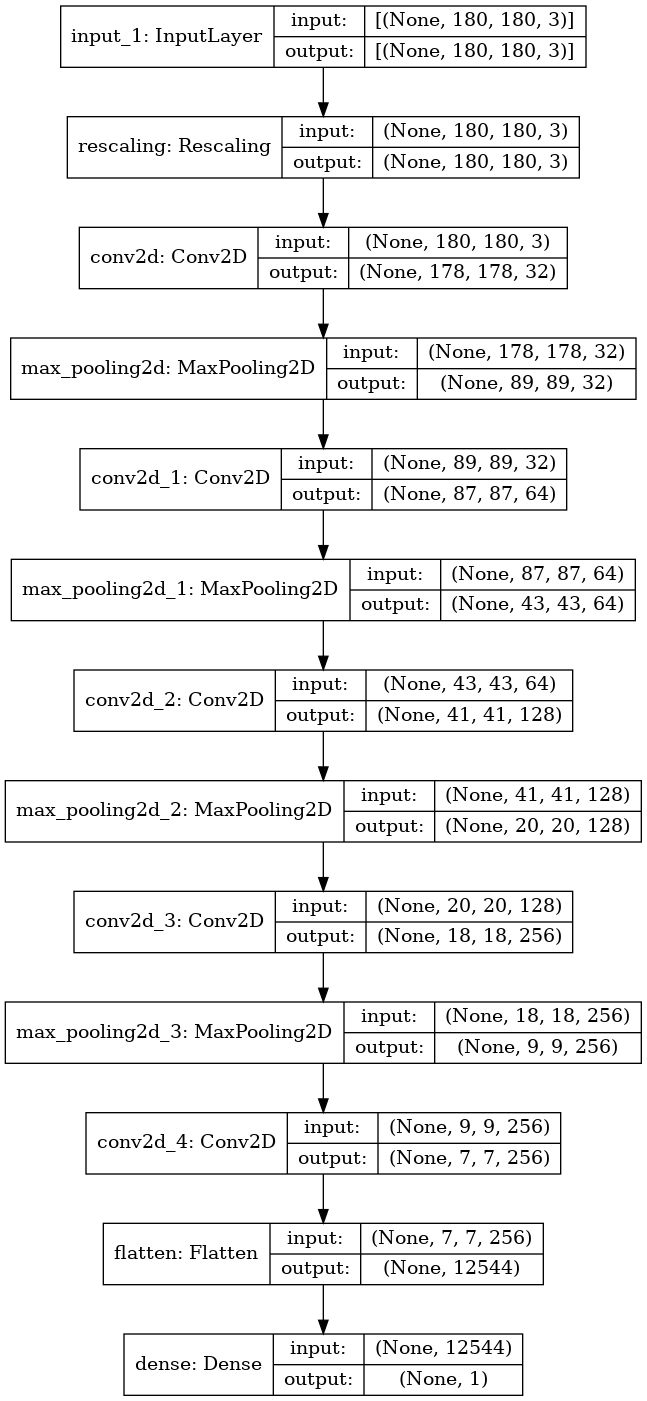

time: 636 ms (started: 2021-07-29 15:36:43 +08:00)


In [164]:
plot_model(model, show_shapes=True)

对于编译步骤，您将像往常一样使用优化器。 因为您使用单个 sigmoid 单元结束了 RMSprop 模型，所以您将使用二元交叉熵作为损失（提醒一下，请查看第 6 章中的表 6.1，了解在各种情况下使用何种损失函数的备忘单）。

In [5]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

time: 36.9 ms (started: 2021-07-30 09:01:00 +08:00)


### 数据预处理

正如您现在所知，在将数据输入模型之前，应将数据格式化为经过适当预处理的浮点张量。 目前，数据作为 JPEG 文件位于驱动器上，因此将其导入模型的步骤大致如下：
* 读取图片文件。
* 将 JPEG 内容解码为 RGB 像素网格。
* 将这些转换为浮点张量。
* 将它们调整为共享大小（我们将使用 180 x 180）。
* 将它们分批打包（我们将使用 32 张图片的批次）。

这似乎有点令人生畏，但幸运的是 Keras 有实用程序可以自动处理这些步骤。 特别是，Keras 具有实用函数 image_dataset_from_directory，它可以让您快速设置数据管道，该管道可以自动将磁盘上的图像文件转换为批量预处理的张量。 这是您将在此处使用的内容。

调用 image_dataset_from_directory(directory) 将首先列出目录的子目录，并假设每个子目录都包含来自您的班级之一的图像。 然后它将索引每个子目录中的图像文件。 最后，它将创建并返回一个 tf.data.Dataset 对象，该对象被配置为读取这些文件，对它们进行混洗，将它们解码为张量，将它们调整为共享大小，并将它们打包成批处理。

> 清单 8.9 使用 image_dataset_from_directory 从目录中读取图像

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os, shutil, pathlib

new_base_dir = pathlib.Path("data/dogs-vs-cats")

train_dataset = image_dataset_from_directory(new_base_dir/"train",
                                             image_size=(180, 180),
                                             batch_size=32)

validation_dataset = image_dataset_from_directory(new_base_dir/"validation",
                                                  image_size=(180, 180),
                                                  batch_size=32)

test_dataset = image_dataset_from_directory(new_base_dir/"test",
                                            image_size=(180, 180),
                                            batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
time: 355 ms (started: 2021-07-30 09:01:09 +08:00)


**了解 TensorFlow 数据集对象**

TensorFlow 提供了 tf.data API 来为机器学习模型创建高效的输入管道。 它的核心类是 tf.data.Dataset。

Dataset 对象是一个迭代器：您可以在 for 循环中使用它。 它通常会返回成批的输入数据和标签。 您可以将 Dataset 对象直接传递给 Keras 模型的 fit() 方法。

Dataset 类处理了许多关键特性，否则它们自己实现起来会很麻烦，特别是异步数据预取（在模型处理前一批数据的同时预处理下一批数据，这样可以保持执行流畅而不会中断）。

Dataset 类还公开了用于修改数据集的函数式 API。 这是一个简单的例子：让我们从随机数的 NumPy 数组创建一个 Dataset 实例。 我们将考虑 1000 个样本，其中每个样本是一个大小为 16 的向量。

In [4]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000, 16))

# from_tensor_slices() 类方法可用于从 NumPy 数组或 NumPy 数组的元组或字典创建数据集。
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

time: 1.64 s (started: 2021-07-30 07:29:31 +08:00)


起初，我们的数据集只产生单个样本：

In [6]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)
time: 48.2 ms (started: 2021-07-30 07:44:06 +08:00)


您可以使用该方法对数据进行批处理：

In [7]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)
time: 28.2 ms (started: 2021-07-30 07:45:00 +08:00)


更广泛地说，您可以访问一系列有用的数据集方法，例如：
* .shuffle(buffer_size) 将洗牌缓冲区内的元素。
* .prefetch(buffer_size) 将预取 GPU 中元素的缓冲区内存以实现更好的设备利用率。
* .map(callable) 将对数据集的每个元素应用任意转换（函数 callable，预期将数据集产生的单个元素作为输入）。

特别是 .map() 方法是您经常使用的方法。 这是一个例子：让我们用它来将我们玩具数据集中的元素从 shape (16,) 重塑为 shape(4, 4) ：

In [8]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)
time: 231 ms (started: 2021-07-30 07:49:21 +08:00)


让我们看看这些对象之一的输出：它生成一批 180 × 180 RGB 数据集图像（形状 (32, 180, 180, 3)）和整数标签（形状 (32,)）。 每批有 32 个样本（批大小）。

In [11]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)
time: 282 ms (started: 2021-07-30 07:53:38 +08:00)


让我们在我们的数据集上拟合模型。 我们使用 fit() 中的 validation_data 参数来监控单独对象上的验证指标。

请注意，我们还使用 ModelCheckpoint 回调在每个 epoch 之后保存模型。 我们使用保存文件的路径以及参数 save_best_only=True 和 monitor="val_loss" 配置它：它们告诉回调只保存一个新文件
（覆盖任何先前的）当 val_loss 度量的当前值低于训练期间的任何先前时间时。 这保证您保存的文件将始终包含与其在验证数据上的性能方面表现最佳的训练时期相对应的模型状态。 因此，如果我们开始过度拟合，我们就不必为较少的 epoch 重新训练新模型：我们只需重新加载保存的文件即可。

In [12]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch.keras",
                                             save_best_only=True,
                                             monitor="val_loss")
            ]

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 5s 77ms/step - loss: 0.3328 - accuracy: 0.8640 - val_loss: 0.6501 - val_accuracy: 0.7490
Epoch 2/20
63/63 [==============================] - 5s 85ms/step - loss: 0.2381 - accuracy: 0.9020 - val_loss: 1.0289 - val_accuracy: 0.7440
Epoch 3/20
63/63 [==============================] - 5s 81ms/step - loss: 0.2141 - accuracy: 0.9140 - val_loss: 0.7359 - val_accuracy: 0.7420
Epoch 4/20
63/63 [==============================] - 6s 92ms/step - loss: 0.1621 - accuracy: 0.9385 - val_loss: 1.1342 - val_accuracy: 0.7200
Epoch 5/20
63/63 [==============================] - 5s 73ms/step - loss: 0.1263 - accuracy: 0.9520 - val_loss: 1.0667 - val_accuracy: 0.7270
Epoch 6/20
63/63 [==============================] - 6s 88ms/step - loss: 0.0961 - accuracy: 0.9625 - val_loss: 1.1929 - val_accuracy: 0.7330
Epoch 7/20
63/63 [==============================] - 6s 102ms/step - loss: 0.0895 - accuracy: 0.9625 - val_loss: 1.1665 - val_accuracy: 0.7450
Epoch 8/20
6

让我们在训练期间绘制模型在训练和验证数据上的损失和准确度（见图 8.9）。

In [9]:
import pandas as pd

time: 516 µs (started: 2021-07-30 09:02:58 +08:00)


In [13]:
df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,val_loss,val_accuracy
0,0.332774,0.8640,0.650096,0.749
1,0.238104,0.9020,1.028909,0.744
2,0.214073,0.9140,0.735892,0.742
3,0.162139,0.9385,1.134232,0.720
4,0.126256,0.9520,1.066735,0.727
5,0.096099,0.9625,1.192866,0.733
6,0.089525,0.9625,1.166486,0.745
7,0.092666,0.9680,1.351704,0.740
8,0.054730,0.9840,1.556000,0.764
9,0.095136,0.9725,1.498555,0.725


time: 43.9 ms (started: 2021-07-30 09:06:09 +08:00)


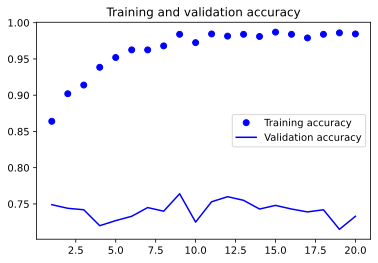

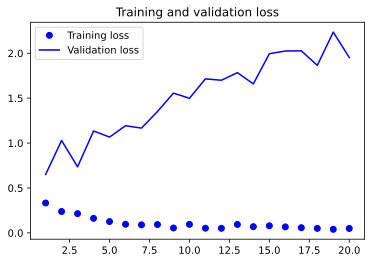

time: 1.45 s (started: 2021-07-30 09:06:14 +08:00)


In [14]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

这些图是过拟合的特征。 训练准确率随时间线性增加，直到接近 100%，而验证准确率最高为 75%。 验证损失仅在 10 个 epoch 后就达到最小值，然后停止，而随着训练的进行，训练损失保持线性下降。

让我们检查测试的准确性。 我们将从其保存的文件中重新加载模型，以便在开始过度拟合之前对其进行评估。

In [15]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 40ms/step - loss: 0.6722 - accuracy: 0.7100
Test accuracy: 0.710
time: 6.2 s (started: 2021-07-30 09:08:13 +08:00)


我们得到了 69.5% 的测试准确率（由于神经网络初始化的随机性，你可能会得到一个百分点以内的数字）。

由于您的训练样本相对较少（2,000 个），过度拟合将是您的第一要务。 您已经了解了许多有助于缓解过度拟合的技术，例如 dropout 和权重衰减（L2 正则化）。 我们现在将使用一种新的方法，专门针对计算机视觉并且在使用深度学习模型处理图像时几乎普遍使用：数据增强。

### 使用数据增强

过拟合是由于可供学习的样本太少导致您无法训练可以泛化到新数据的模型。 给定无限数据，您的模型将暴露于手头数据分布的每个可能方面：您永远不会过度拟合。 数据增强采用从现有训练样本生成更多训练数据的方法，方法是通过大量随机变换来增强样本，从而产生看起来可信的图像。 目标是在训练时，您的模型永远不会看到两次完全相同的图片。 这有助于将模型暴露于数据的更多方面并更好地概括。

在 Keras 中，这可以通过在模型开始时添加多个数据增强层来完成。 让我们从一个例子开始：这是一个序列模型，它链接了几个随机图像转换。 在我们的模型中，我们将它包含在 Rescaling 层之前。

In [22]:
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal"),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.2),
                                     ])

time: 19.6 ms (started: 2021-07-30 09:18:36 +08:00)


这些只是一些可用的层（有关更多信息，请参阅 Keras 文档）。 让我们快速浏览一下这段代码：
* RandomFlip("horizontal") 将对通过它的随机 50% 的图像应用水平翻转。
* RandomRotation(0.1) 将通过 [-10%, +10%] 范围内的随机值旋转输入图像（这些是完整圆的分数 - 范围为 [-36 度，+36 度]） .
* RandomZoom(0.2) 将按 [-20%, +20%] 范围内的随机因子放大或缩小图像。

让我们看看增强的图像（见图 8.10）。

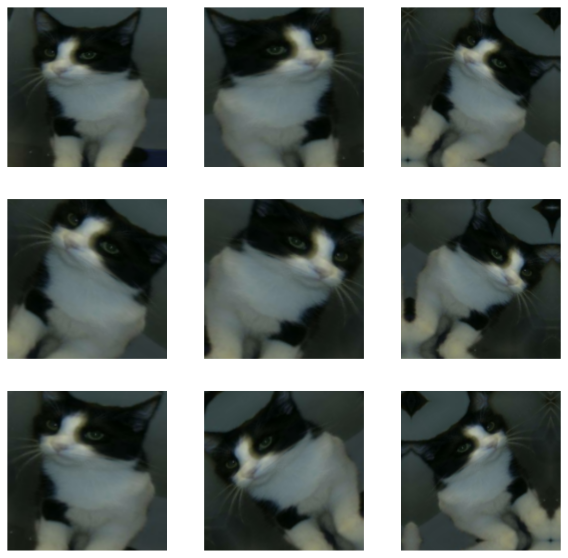

time: 3.34 s (started: 2021-07-30 09:25:12 +08:00)


In [29]:
plt.figure(figsize=(10, 10))

# 您可以使用仅从数据集中采样 N 个批次。 这等效于 take(N) 在第 N 个批次之后在循环中插入一个中断。
for images, _ in train_dataset.take(1): 
    for i in range(9):
#         将增强阶段应用于这批图像。
        augmented_images = data_augmentation(images) 
        ax = plt.subplot(3, 3, i + 1)
#         显示输出批次中的第一张图像。 对于九次迭代中的每一次，这是同一图像的不同增强。
        plt.imshow(augmented_images[0].numpy().astype("uint8")) 
        plt.axis("off")

如果您使用此数据增强配置训练新模型，该模型将永远不会看到相同的输入两次。 但是它看到的输入仍然是高度相关的，因为它们来自少量的原始图像——你不能产生新的信息，你只能重新混合现有的信息。 因此，这可能不足以完全摆脱过度拟合。 为了进一步对抗过度拟合，您还将在模型中添加一个 Dropout 层，就在密集连接的分类器之前。

关于随机图像增强层你应该知道的最后一件事：就像 Dropout 一样，它们在推理过程中是不活动的（当你调用 predict() 或 evaluate() 时）。 在评估期间，您的模型的行为将与不包括数据增强和丢失时的行为相同。

> 清单 8.20 定义一个包含图像增强和 dropout 的新 convnet

In [30]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

time: 696 ms (started: 2021-07-30 09:27:45 +08:00)


让我们使用数据增强和丢弃来训练模型。 因为我们预计过拟合会在训练过程中发生得更晚，所以我们将训练 3 倍的 epoch——100。

In [31]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch_with_augmentation.keras",
                                            save_best_only=True,
                                             monitor="val_loss")]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 9s 89ms/step - loss: 0.7229 - accuracy: 0.5065 - val_loss: 0.6898 - val_accuracy: 0.5630
Epoch 2/100
63/63 [==============================] - 6s 95ms/step - loss: 0.6997 - accuracy: 0.5585 - val_loss: 0.6724 - val_accuracy: 0.5730
Epoch 3/100
63/63 [==============================] - 8s 117ms/step - loss: 0.6857 - accuracy: 0.5820 - val_loss: 0.7088 - val_accuracy: 0.5710
Epoch 4/100
63/63 [==============================] - 6s 99ms/step - loss: 0.6764 - accuracy: 0.6210 - val_loss: 0.6456 - val_accuracy: 0.5840
Epoch 5/100
63/63 [==============================] - 8s 126ms/step - loss: 0.6388 - accuracy: 0.6495 - val_loss: 0.9191 - val_accuracy: 0.5270
Epoch 6/100
63/63 [==============================] - 6s 101ms/step - loss: 0.6177 - accuracy: 0.6555 - val_loss: 0.5894 - val_accuracy: 0.6730
Epoch 7/100
63/63 [==============================] - 5s 84ms/step - loss: 0.6136 - accuracy: 0.6810 - val_loss: 0.7613 - val_accuracy: 0.5870
Epo

让我们再次绘制结果：见图 8.11。 由于数据增强和 dropout，我们开始过拟合的时间要晚得多，大约是 60-70 epochs（与原始模型的 epoch 10 相比）。 验证准确率始终保持在 80-85% 的范围内——与我们的第一个相比有了很大的改进
尝试。

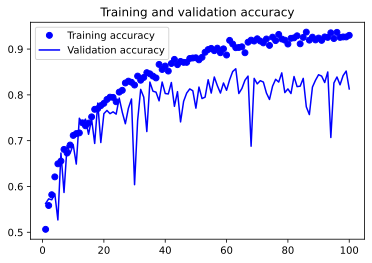

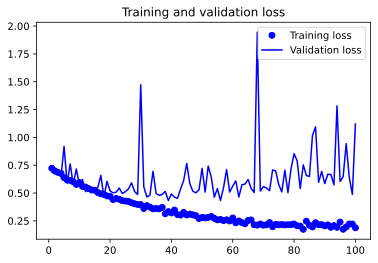

time: 460 ms (started: 2021-07-30 09:48:14 +08:00)


In [32]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

让我们检查测试的准确性：

In [33]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 32ms/step - loss: 0.4650 - accuracy: 0.8255
Test accuracy: 0.826
time: 3.72 s (started: 2021-07-30 09:49:05 +08:00)


我们得到了 83.5% 的测试准确率。 开始好看了！ 如果您使用 Colab，请确保下载保存的文件 (convnet_from_scratch_with_augmentation.keras)，因为我们将在下一章中用于一些实验。

通过进一步调整模型的配置（例如每个卷积层的过滤器数量，或模型中的层数），您可以获得更好的准确率，可能高达 90%。 但事实证明，仅仅通过从头开始训练你自己的 convnet 就很难再提高了，因为你可以使用的数据太少了。 作为提高此问题准确性的下一步，您必须使用预训练模型，这是接下来两节的重点。

## 利用预训练模型

在小图像数据集上进行深度学习的一种常见且高效的方法是使用预训练模型。预训练模型是先前在大型数据集上训练过的模型，通常用于大规模图像分类任务。如果这个原始数据集足够大且足够通用，那么预训练模型学习的特征的空间层次可以有效地充当视觉世界的通用模型，因此它的特征可以证明对许多不同的计算机视觉问题有用，甚至尽管这些新问题可能涉及与原始任务完全不同的类。例如，您可以在 ImageNet 上训练一个模型（其中的类主要是动物和日常物品），然后将这个训练过的模型重新用于识别图像中的家具物品等远程任务。与许多旧的浅层学习方法相比，学习特征在不同问题上的这种可移植性是深度学习的一个关键优势，它使深度学习对于小数据问题非常有效。

在这种情况下，让我们考虑在 ImageNet 数据集（140 万张标记图像和 1,000 个不同类别）上训练的大型 convnet。 ImageNet 包含许多动物类别，包括不同种类的猫和狗，因此您可以期望它在狗与猫分类问题上表现良好。

您将使用由 Karen Simonyan 和 Andrew Zisserman 于 2014 年开发的 VGG16 架构。虽然它是一个较旧的模型，与当前最先进的模型相去甚远，而且比许多其他最近的模型重一些，但我选择它是因为它的架构类似于在不引入任何新概念的情况下，您已经熟悉并且易于理解的内容。这可能是您第一次遇到这些可爱的模型名称之一——VGG、ResNet、Inception、Xception 等等；你会习惯它们，因为如果你继续为计算机视觉进行深度学习，它们会经常出现。

有两种使用预训练模型的方法：特征提取和微调.我们将涵盖两者。让我们从特征提取开始。

### 使用预训练模型进行特征提取

特征提取包括使用先前训练的模型学习的表示从新样本中提取有趣的特征。 这些特征然后通过一个新的分类器运行，该分类器从头开始训练。

正如您之前看到的，用于图像分类的 convnets 包括两部分：它们以一系列池化和卷积层开始，它们以一个密集连接的分类器结束。
第一部分称为模型的卷积基。 在 convnets 的情况下，特征提取包括获取先前训练过的网络的卷积基，通过它运行新数据，并在输出之上训练一个新的分类器（见图 8.12）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsyqtzdeu4j312s0syjto.jpg)

为什么只重用卷积基？你也可以重用密集连接的分类器吗？一般来说，应该避免这样做。原因是卷积基学习的表示可能更通用，因此更可重用：卷积网络的特征图是图片上通用概念的存在图，无论计算机视觉如何，这都可能有用手头的问题。但是分类器学习到的表示必须特定于模型训练的类别集——它们将只包含关于整个图片中这个或那个类的存在概率的信息。此外，在密集连接层中发现的表示不再包含有关对象在输入图像中的位置的任何信息：这些层摆脱了空间的概念，而对象位置仍然由卷积特征图描述。对于对象位置很重要的问题，密集连接的特征在很大程度上是无用的。

请注意，由特定卷积层提取的表征的通用性（以及因此可重用性）水平取决于模型中层的深度。 模型中较早的层提取局部的、高度通用的特征图（例如视觉边缘、颜色和纹理），而较高的层提取更抽象的概念（例如“猫耳”或“狗眼”） . 因此，如果您的新数据集与训练原始模型的数据集有很大不同，您最好只使用模型的前几层进行特征提取，而不是使用整个卷积基础。

在这种情况下，由于 ImageNet 类集包含多个狗和猫类，因此重用原始模型的密集连接层中包含的信息可能是有益的。 但是我们会选择不这样做，以涵盖更一般的情况，即新问题的类集与原始模型的类集不重叠。 让我们通过使用在 ImageNet 上训练的 VGG16 网络的卷积基础将其付诸实践，从猫和狗的图像中提取有趣的特征，然后在这些特征之上训练狗对猫分类器。

Keras预装了 VGG16 模型和其他模型。 您可以从 keras.applications 模块导入它。 许多其他图像分类模型（均在 ImageNet 数据集上预训练）可作为 keras.applications 的一部分使用：
* Xception
* ResNet
* MobileNet
* EfficientNet
* DenseNet
* etc.

让我们实例化 VGG16 模型。

In [34]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet",
                                           include_top=False,
                                           input_shape=(180, 180, 3))

58892288/58889256 [==============================] - 69s 1us/step
time: 1min 10s (started: 2021-07-30 10:04:46 +08:00)


您将两个参数传递给构造函数：
* weights 指定用于初始化模型的权重检查点。
* include_top 是指在网络顶部包含（或不包含）密集连接的分类器。 默认情况下，这个密集连接的分类器对应于来自 ImageNet 的 1,000 个类。 因为您打算使用自己的密集连接分类器（只有两个类：和），所以不需要包含它。
* input_shape 是您将提供给网络的图像张量的形状。 这个参数完全是可选的：如果你不传递它，网络将能够处理任何大小的输入。 在这里，我们通过，以便我们可以在下面的摘要中可视化特征图的大小如何随着每个新的卷积和池化层而缩小。

这是 VGG16 卷积基的架构细节。 它类似于您已经熟悉的 simple convnets：

In [35]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

最终的特征图具有形状 (5, 5, 512)。 这是特征图，您将在其上放置一个密集连接的分类器。

In [36]:
from tensorflow.keras.utils import plot_model

time: 1.33 ms (started: 2021-07-30 10:23:41 +08:00)


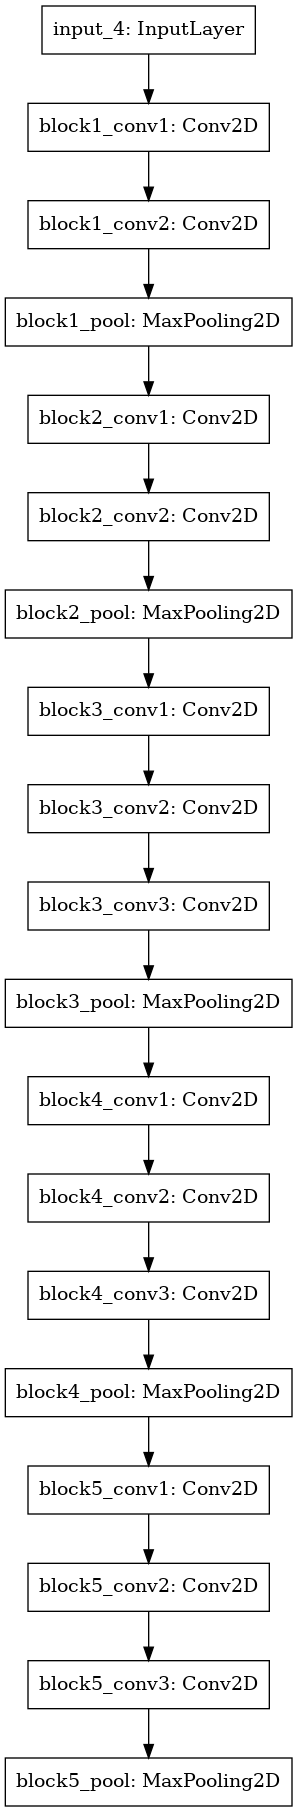

time: 1.25 s (started: 2021-07-30 10:23:51 +08:00)


In [37]:
plot_model(conv_base)

此时，您可以通过两种方式进行操作：
* 在数据集上运行卷积基，将其输出记录到磁盘上的 NumPy 数组，然后将此数据用作独立的、密集连接的分类器的输入，类似于您在本书第 1 部分中看到的分类器。 这个解决方案运行起来既快速又便宜，因为它只需要为每个输入图像运行一次卷积基，而卷积基是迄今为止流水线中最昂贵的部分。 但出于同样的原因，这种技术不允许您使用数据增强。
* 通过在顶部添加 Dense 层来扩展您拥有的模型 (conv_base)，并在输入数据上端到端地运行整个过程。 这将允许您使用数据增强，因为每个输入图像每次被模型看到时都会通过卷积基。 但出于同样的原因，这种技术比第一种技术昂贵得多。

我们将介绍这两种技术。 让我们来看看设置第一个所需的代码：记录数据的输出并将这些输出用作新 conv_base 模型的输入。

**无需数据增强的快速特征提取**

您将首先将特征提取为 NumPy 数组，方法是在我们的训练、验证和测试数据集上调用 conv_base 模型的 predict() 方法。

让我们迭代我们的数据集以提取 VGG16 特征：

> 清单 8.24 提取 VGG16 特征和对应的标签

In [39]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

time: 53.1 s (started: 2021-07-30 10:49:59 +08:00)


重要的是，predict() 只需要图像，而不是标签，但我们当前的数据集会生成包含图像及其标签的批次。 此外，该模型需要使用函数 keras.applications.vgg16.preprocess_input 进行 VGG16 预处理的输入，该函数将像素值缩放到适当的范围。

提取的特征当前是形状（samples，5, 5, 512）：

In [41]:
train_features.shape

(2000, 5, 5, 512)

time: 3.34 ms (started: 2021-07-30 10:52:29 +08:00)


此时，您可以定义您的密集连接分类器（注意使用 dropout 进行正则化）并在您刚刚记录的数据和标签上对其进行训练。

> 清单 8.25 定义和训练密集连接的分类器

In [42]:
inputs = keras.Input(shape=(5, 5, 512))

# 请注意在将要素传递给图层之前使用 Flatten 图层。
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras",
                                             save_best_only=True,
                                             monitor="val_loss")]

history = model.fit(train_features, 
                    train_labels,
                    epochs=20,
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 27ms/step - loss: 20.5747 - accuracy: 0.9175 - val_loss: 7.6035 - val_accuracy: 0.9520
Epoch 2/20
63/63 [==============================] - 1s 19ms/step - loss: 3.1017 - accuracy: 0.9765 - val_loss: 7.4148 - val_accuracy: 0.9540
Epoch 3/20
63/63 [==============================] - 1s 20ms/step - loss: 1.4701 - accuracy: 0.9870 - val_loss: 9.7259 - val_accuracy: 0.9550
Epoch 4/20
63/63 [==============================] - 1s 21ms/step - loss: 1.5159 - accuracy: 0.9890 - val_loss: 4.6488 - val_accuracy: 0.9710
Epoch 5/20
63/63 [==============================] - 1s 20ms/step - loss: 0.5314 - accuracy: 0.9945 - val_loss: 8.3422 - val_accuracy: 0.9620
Epoch 6/20
63/63 [==============================] - 1s 19ms/step - loss: 0.6771 - accuracy: 0.9925 - val_loss: 5.7011 - val_accuracy: 0.9700
Epoch 7/20
63/63 [==============================] - 1s 20ms/step - loss: 0.4349 - accuracy: 0.9970 - val_loss: 5.4791 - val_accuracy: 0.9740
Epoch 8/20
6

训练非常快，因为你只需要处理两层——即使在 CPU 上，一个 epoch 的 Dense 时间也少于一秒。

让我们看看训练期间的损失和准确率曲线（见图 8.13）。

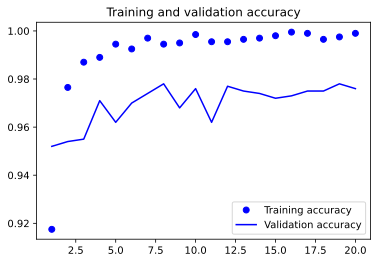

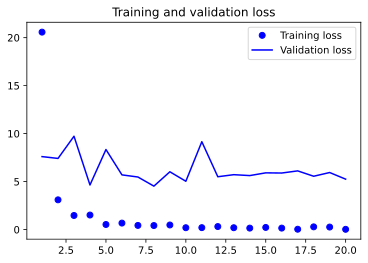

time: 1.53 s (started: 2021-07-30 11:13:57 +08:00)


In [43]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

你达到了大约 97% 的验证准确率——比你在上一节中使用从头开始训练的小模型实现的要好得多。 然而，这有点不公平，因为 ImageNet 包含许多狗和猫的实例，这意味着我们的预训练模型已经拥有手头任务所需的准确知识。 当您使用预训练功能时，情况并非总是如此。 

然而，这些图也表明你几乎从一开始就过度拟合了——尽管使用 dropout 的比率相当大。 这是因为该技术不使用数据增强，这对于防止小图像数据集过度拟合至关重要。

**特征提取与数据增强**

现在，让我们回顾一下我提到的用于进行特征提取的第二种技术，它更慢且成本更高，但它允许您在训练期间使用数据增强：创建一个将 conv_base 与新的密集分类器链接起来的模型，然后训练它结束 以输入结束。

为此，我们将首先冻结卷积基。 冻结一层或一组层意味着防止它们的权重在训练期间更新。 在这里，如果你不这样做，那么先前由卷积基学习的表示将在训练过程中被修改。 因为顶部的密集层是随机初始化的，非常大的权重更新将通过网络传播，有效地破坏了先前学习的表示。

在 Keras 中，您可以通过将其trainable属性设置为false 来冻结层或模型：

> 清单 8.27 实例化和冻结 VGG16 卷积基

In [45]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
conv_base.trainable = False

time: 808 ms (started: 2021-07-30 11:19:17 +08:00)


设置为 False 会清空层或模型的可训练权重列表：

> 清单 8.28 打印冻结前后的可训练权重列表

In [48]:
conv_base.trainable = True
print("This is the number of trainable weights " \
       "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
time: 3.34 ms (started: 2021-07-30 11:21:16 +08:00)


In [49]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0
time: 3.67 ms (started: 2021-07-30 11:21:40 +08:00)


现在，我们可以创建一个链接在一起的新模型：
* 数据增强阶段
* 我们冻结的卷积基础
* 密集分类器

> 清单 8.29 向冻结卷积基添加数据增强和密集连接分类器

In [50]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2), ])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop",
              metrics=["accuracy"])

time: 465 ms (started: 2021-07-30 11:25:43 +08:00)


使用此设置，只会训练来自您添加的两个 Dense 层的权重。 总共有四个权重张量：每层两个（主权重矩阵和偏置向量）。 请注意，为了使这些更改生效，您必须首先编译模型。 如果您在编译后修改了权重可训练性，则应重新编译模型，否则这些更改将被忽略。

让我们训练我们的模型。 由于数据增强，模型开始过拟合需要更长的时间，所以我们可以训练更多的 epoch——让我们做 50 个。

> 这种技术非常昂贵，只有在您可以访问 GPU（例如 Colab 中可用的免费 GPU）时才应该尝试它——它在 CPU 上是难以处理的。 如果你不能在 GPU 上运行你的代码，那么前面的技术就是要走的路。

In [51]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 12s 158ms/step - loss: 32.0639 - accuracy: 0.8500 - val_loss: 8.7051 - val_accuracy: 0.9430
Epoch 2/50
63/63 [==============================] - 8s 129ms/step - loss: 11.6740 - accuracy: 0.9105 - val_loss: 21.4698 - val_accuracy: 0.9040
Epoch 3/50
63/63 [==============================] - 8s 132ms/step - loss: 11.1888 - accuracy: 0.9170 - val_loss: 9.3145 - val_accuracy: 0.9480
Epoch 4/50
63/63 [==============================] - 9s 147ms/step - loss: 8.8778 - accuracy: 0.9355 - val_loss: 7.6843 - val_accuracy: 0.9550
Epoch 5/50
63/63 [==============================] - 7s 110ms/step - loss: 8.4744 - accuracy: 0.9335 - val_loss: 4.6188 - val_accuracy: 0.9640
Epoch 6/50
63/63 [==============================] - 9s 145ms/step - loss: 6.5382 - accuracy: 0.9425 - val_loss: 11.8093 - val_accuracy: 0.9280
Epoch 7/50
63/63 [==============================] - 8s 121ms/step - loss: 5.3501 - accuracy: 0.9490 - val_loss: 16.3503 - val_accuracy: 0.9160

让我们再次绘制结果（见图 8.14）。 如您所见，您达到了超过 98% 的验证准确率。 与之前的模型相比，这是一个很大的改进。

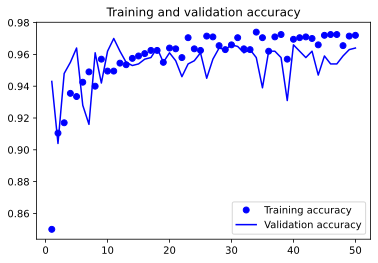

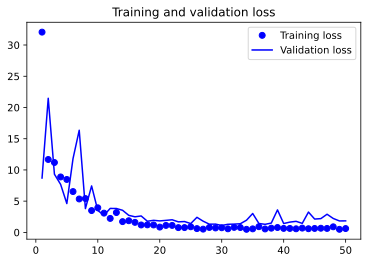

time: 519 ms (started: 2021-07-30 11:53:14 +08:00)


In [53]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

让我们检查测试的准确性：

In [52]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)

print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 81ms/step - loss: 1.4258 - accuracy: 0.9670
Test accuracy: 0.967
time: 8.99 s (started: 2021-07-30 11:35:24 +08:00)


我们得到了 97.5% 的测试准确率。 与之前的测试准确性相比，这只是一个适度的改进，考虑到验证数据的强劲结果，这有点令人失望。 模型的准确性始终取决于您评估它的样本集！ 一些样本集可能比其他样本集更难，并且在一个集上的强结果不一定完全转化为所有其他集。

### 微调预训练模型

另一种广泛使用的模型重用技术是微调，是对特征提取的补充（见图 8.15）。 微调包括解冻用于特征提取的冻结模型库的一些顶层，并联合训练模型的新添加部分（在本例中为全连接分类器）和这些顶层。 这被称为微调，因为它稍微调整了被重用模型的更抽象的表示，以使它们与手头的问题更相关。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsyu5eg3ptj30po0s8gnb.jpg)

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsyu5s7oqfj30f80nwmyi.jpg)

我之前说过有必要冻结 VGG16 的卷积基，以便能够在上面训练一个随机初始化的分类器。出于同样的原因，只有在顶层的分类器已经被训练之后，才有可能对卷积基的顶层进行微调。如果分类器还没有经过训练，那么在训练过程中通过网络传播的误差信号会过大，并且先前被微调的层学习的表示将被破坏。因此，微调网络的步骤如下：
* 在已经训练好的基础网络之上添加您的自定义网络。
* 冻结基础网络。
* 训练您添加的部分。
* 解冻基础网络中的一些层。 （请注意，您不应解冻“batch normalization”层，这与此处无关，因为 VGG16 中没有此类层。批量标准化及其对微调的影响将在下一章中说明。）
* 联合训练这些层和您添加的部分。

在进行特征提取时，您已经完成了前三个步骤。 让我们继续第 4 步：您将解冻 conv_base，然后冻结其中的各个层。

提醒一下，这就是你的卷积基的样子：

In [54]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

您将微调最后三个卷积层，这意味着应冻结直到 block4_pool 的所有层，并且层 block5_conv1、block5_conv2、block5_conv3 和应为
可训练。

为什么不微调更多层？ 为什么不微调整个卷积基？ 你可以。 但是您需要考虑以下几点：
* 卷积基础中较早的层编码更通用的、可重用的特征，而更高的层编码更专业的特征。 微调更专业的功能会更有用，因为这些功能需要重新用于您的新问题。 微调较低层的回报会快速下降。
* 你训练的参数越多，过拟合的风险就越大。 卷积基础有 1500 万个参数，因此尝试在您的小数据集上训练它是有风险的。

因此，在这种情况下，仅对卷积基础中的前两层或三层进行微调是一个很好的策略。 让我们从上一个示例中停止的地方开始进行设置。

> 清单 8.31 冻结所有层直到倒数第四个

In [55]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

time: 4.35 ms (started: 2021-07-30 12:02:46 +08:00)


现在您可以开始微调模型。 您将使用 RMSprop 优化器执行此操作，并使用非常低的学习率。 使用低学习率的原因是你想限制你对正在微调的三个层的表示所做的修改的幅度。 太大的更新可能会损害这些表示。

In [56]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")]

history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 169ms/step - loss: 0.4185 - accuracy: 0.9790 - val_loss: 1.8878 - val_accuracy: 0.9660
Epoch 2/30
63/63 [==============================] - 9s 142ms/step - loss: 0.4875 - accuracy: 0.9775 - val_loss: 1.7459 - val_accuracy: 0.9640
Epoch 3/30
63/63 [==============================] - 10s 152ms/step - loss: 0.4623 - accuracy: 0.9770 - val_loss: 1.5880 - val_accuracy: 0.9650
Epoch 4/30
63/63 [==============================] - 9s 138ms/step - loss: 0.3503 - accuracy: 0.9815 - val_loss: 1.9998 - val_accuracy: 0.9560
Epoch 5/30
63/63 [==============================] - 9s 142ms/step - loss: 0.3418 - accuracy: 0.9795 - val_loss: 1.2914 - val_accuracy: 0.9710
Epoch 6/30
63/63 [==============================] - 9s 148ms/step - loss: 0.1781 - accuracy: 0.9870 - val_loss: 1.4533 - val_accuracy: 0.9670
Epoch 7/30
63/63 [==============================] - 10s 150ms/step - loss: 0.2618 - accuracy: 0.9875 - val_loss: 1.5100 - val_accuracy: 0.9670
Epo

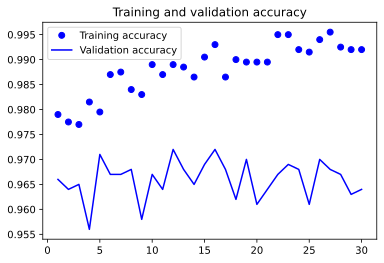

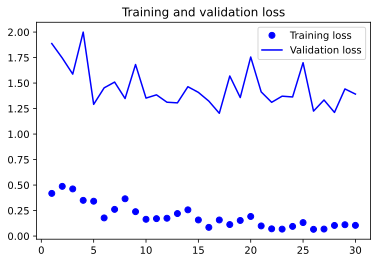

time: 1.72 s (started: 2021-07-30 12:13:45 +08:00)


In [59]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

您现在可以最终在测试数据上评估此模型：

In [57]:
model = keras.models.load_model("fine_tuning.keras")

test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 69ms/step - loss: 1.4457 - accuracy: 0.9695
Test accuracy: 0.970
time: 8.91 s (started: 2021-07-30 12:09:01 +08:00)


在这里，您获得了 98.5% 的测试准确率（同样，您自己的结果可能在 1 个百分点以内）。 在围绕这个数据集的原始 Kaggle 比赛中，这将是最好的结果之一。 然而，这并不是一个公平的比较，因为您使用了预先训练的特征，这些特征已经包含了有关猫和狗的先验知识，而竞争对手当时无法使用这些知识。

从积极的方面来说，通过利用现代深度学习技术，您仅使用比赛可用的一小部分训练数据（约 10%）就成功地达到了这一结果。 能够训练 20,000 个样本与 2,000 个样本之间存在巨大差异！

现在您拥有一套可靠的工具来处理图像分类问题——尤其是小数据集。

## 章节总结

* Convnets 是用于计算机视觉任务的最佳机器学习模型类型。 即使在非常小的数据集上，也可以从头开始训练，并获得不错的结果。
* Convnets 通过学习模块化模式和概念的层次结构来表示视觉世界。
* 在小数据集上，过度拟合将是主要问题。 当您处理图像数据时，数据增强是一种对抗过度拟合的有效方法。
* 通过特征提取很容易在新数据集上重用现有的卷积网络。 这是处理小型图像数据集的一项有价值的技术。
* 作为特征提取的补充，您可以使用微调，它可以适应现有模型先前学习的一些表示的新问题。 这进一步推动了性能。